# Phase 5: P.1812 Loss Calculation

**Phase 5**: Process Phase 4 CSV profiles through ITU-R P.1812-6 model and calculate radio propagation loss.

This notebook:
- Loads CSV profiles from Phase 4 (already P.1812-ready with transmitter point at d=0)
- Processes each profile using P.1812 bt_loss() function
- Calculates basic transmission loss (Lb) and electric field strength (Ep)
- Exports results to structured DataFrame and CSV file

## Prerequisites
- Phase 0: Setup (defines CONFIG, project_root, data directories)
- Phase 1-4: Must be completed to generate P.1812-ready CSV profiles

## Output
- CSV file: `data/output/spreadsheets/p1812_results.csv`
- Summary statistics and visualizations

## 1. Setup from Phase 0

In [9]:
%run phase0_setup.ipynb

✓ All imports successful
Project root: /Users/oz/Documents/mst_gis
✓ All data directories created
  profiles: /Users/oz/Documents/mst_gis/data/input/profiles
  api_data: /Users/oz/Documents/mst_gis/data/intermediate/api_data
  reference: /Users/oz/Documents/mst_gis/data/input/reference
  output: /Users/oz/Documents/mst_gis/data/output/spreadsheets
Transmitter: (9.345, -13.40694)
Azimuths: 36 | Profile points: 366
Frequency: 0.9 GHz | Polarization: 1

✓ Transmitter created:
  Transmitter(tx_id='TX_0001', lon=-13.40694, lat=9.345, htg=57, f=0.9, pol=1, p=50, hrg=10)

Seeding elevation data...
make: Nothing to be done for `download'.
make: Nothing to be done for `all'.
✓ Elevation data ready (0.04s)
  Cache location: /Users/oz/Documents/mst_gis/data/intermediate/elevation_cache
  Downloaded 1 DEM tile(s)
    - intermediate/elevation_cache/SRTM1/cache/N09/N09W014.tif

PHASE 0 COMPLETE: Setup ready for subsequent phases

Next steps:
  1. Run Phase 1 to download/cache land cover data
  2. Ru

## 4. Load CSV Profiles

In [10]:
def load_profiles(profiles_dir: Path) -> List[List[str]]:
    """
    Load all CSV profiles from directory.
    Skip header rows.
    """
    profiles = []
    
    csv_files = list(profiles_dir.glob("*.csv"))
    print(f"Loading {len(csv_files)} profile file(s)...")
    
    for file in csv_files:
        print(f"  Loading: {file.name}")
        with file.open(newline="", encoding="utf-8") as f:
            # Skip header (first line), read remaining rows
            rows = list(csv.reader(f, delimiter=";"))[1:]
            profiles.extend(rows)
            print(f"    -> {len(rows)} profiles")
    
    print(f"\nTotal profiles: {len(profiles)}")
    return profiles

# Load all profiles
profiles = load_profiles(profiles_dir)

if not profiles:
    print("\n⚠ WARNING: No profiles found!")
    print("Make sure Phase 4 has been executed to generate CSV profiles.")

Loading 1 profile file(s)...
  Loading: paths_oneTx_manyRx_11km.csv
    -> 36 profiles

Total profiles: 36


## 5. Parse Profile Parameters

In [11]:
def process_loss_parameters(profile: List[str]) -> Tuple:
    """
    Parse CSV row into P.1812 bt_loss() parameters.
    
    CSV columns (first 14 used, skip azimuth at index 14):
    0: f (frequency)
    1: p (time percentage)
    2: d (distance array - starts at 0, added by Phase 4)
    3: h (height array)
    4: R (resistance array)
    5: Ct (land cover category array)
    6: zone (zone ID array)
    7: htg (TX antenna height)
    8: hrg (RX antenna height)
    9: pol (polarization)
    10: phi_t (TX latitude)
    11: phi_r (RX latitude)
    12: lam_t (TX longitude)
    13: lam_r (RX longitude)
    14: azimuth (skip)
    """
    # Parse first 14 columns
    parameters = [ast.literal_eval(parameter) for parameter in profile[0:14]]
    
    return (
        float(parameters[0]),                                  # f: frequency (GHz)
        float(parameters[1]),                                  # p: time percentage (%)
        np.array([float(v) for v in parameters[2]]),          # d: distances (km)
        np.array([float(v) for v in parameters[3]]),          # h: heights (m)
        np.array([float(v) for v in parameters[4]]),          # R: resistances (ohms)
        np.array([int(v) for v in parameters[5]]),            # Ct: land cover categories
        np.array([int(v) for v in parameters[6]]),            # zone: zone IDs
        float(parameters[7]),                                  # htg: TX antenna height (m)
        float(parameters[8]),                                  # hrg: RX antenna height (m)
        int(parameters[9]),                                    # pol: polarization
        float(parameters[10]),                                 # phi_t: TX latitude
        float(parameters[11]),                                 # phi_r: RX latitude
        float(parameters[12]),                                 # lam_t: TX longitude
        float(parameters[13]),                                 # lam_r: RX longitude
    )

# Test on first profile
if profiles:
    params = process_loss_parameters(profiles[0])
    print(f"Profile 1 parameters:")
    print(f"  Frequency: {params[0]} GHz")
    print(f"  Time %: {params[1]}%")
    print(f"  Distance points: {len(params[2])}")
    print(f"  First distance (TX point): {params[2][0]} km")
    print(f"  Last distance (RX point): {params[2][-1]:.2f} km")
    print(f"  TX location: lat={params[10]:.4f}, lon={params[12]:.4f}")

Profile 1 parameters:
  Frequency: 0.9 GHz
  Time %: 50.0%
  Distance points: 368
  First distance (TX point): 0.0 km
  Last distance (RX point): 11.01 km
  TX location: lat=9.3453, lon=-13.4069


## 6. Execute P.1812 Loss Calculation

In [12]:
def calculate_p1812_loss(parameters: Tuple) -> Tuple[float, float]:
    """
    Call P.1812 bt_loss() function.
    
    Returns (Lb, Ep) where:
    - Lb: Basic transmission loss (dB)
    - Ep: Electric field strength (dBμV/m)
    """
    try:
        Lb, Ep = Py1812.P1812.bt_loss(*parameters)
        return float(Lb), float(Ep)
    except Exception as e:
        print(f"  ⚠ Error: {e}")
        return np.nan, np.nan

# Test on first profile
if profiles:
    print("Testing P.1812 calculation...")
    params = process_loss_parameters(profiles[0])
    start = time.perf_counter()
    Lb, Ep = calculate_p1812_loss(params)
    elapsed = time.perf_counter() - start
    
    if not np.isnan(Lb):
        print(f"✓ Success:")
        print(f"  Lb: {Lb:.2f} dB")
        print(f"  Ep: {Ep:.2f} dBμV/m")
    else:
        print(f"✗ Failed (NaN result)")
    print(f"  Time: {elapsed:.4f} seconds")

Testing P.1812 calculation...
✓ Success:
  Lb: 128.74 dB
  Ep: 69.71 dBμV/m
  Time: 0.0009 seconds


## 7. Process All Profiles

In [13]:
def process_all_profiles(profiles: List[List[str]]) -> pd.DataFrame:
    """
    Process all profiles through P.1812.
    """
    results = []
    failed = 0
    start_total = time.perf_counter()
    
    for idx, profile in enumerate(profiles):
        try:
            params = process_loss_parameters(profile)
            Lb, Ep = calculate_p1812_loss(params)
            
            f, p, d, h, R, Ct, zone, htg, hrg, pol, phi_t, phi_r, lam_t, lam_r = params
            
            results.append({
                'profile_id': idx + 1,
                'frequency_ghz': f,
                'time_percentage': p,
                'polarization': pol,
                'tx_lat': phi_t,
                'tx_lon': lam_t,
                'rx_lat': phi_r,
                'rx_lon': lam_r,
                'antenna_height_tx_m': htg,
                'antenna_height_rx_m': hrg,
                'max_distance_km': float(d[-1]),
                'num_distance_points': len(d),
                'Lb_dB': Lb,
                'Ep_dBuV_m': Ep,
            })
            
            if (idx + 1) % 10 == 0:
                print(f"  {idx + 1}/{len(profiles)}...")
        except Exception as e:
            failed += 1
    
    elapsed = time.perf_counter() - start_total
    print(f"\n✓ Complete: {len(results)}/{len(profiles)} succeeded in {elapsed:.2f}s")
    
    return pd.DataFrame(results)

# Process all
if profiles:
    print(f"Processing {len(profiles)} profiles...\n")
    results_df = process_all_profiles(profiles)
else:
    results_df = pd.DataFrame()

Processing 36 profiles...

  10/36...
  20/36...
  30/36...

✓ Complete: 36/36 succeeded in 0.08s


## 8. Results Summary

In [14]:
if not results_df.empty:
    print(f"Shape: {results_df.shape}")
    print(f"\nFirst 5 rows:")
    print(results_df.head())
    print(f"\nStatistics:")
    print(results_df[['Lb_dB', 'Ep_dBuV_m']].describe())
else:
    print("No results")

Shape: (36, 14)

First 5 rows:
   profile_id  frequency_ghz  time_percentage  polarization    tx_lat  \
0           1            0.9             50.0             1  9.345271   
1           2            0.9             50.0             1  9.345267   
2           3            0.9             50.0             1  9.345254   
3           4            0.9             50.0             1  9.345234   
4           5            0.9             50.0             1  9.345207   

      tx_lon    rx_lat     rx_lon  antenna_height_tx_m  antenna_height_rx_m  \
0 -13.406939  9.444546 -13.406485                 57.0                 10.0   
1 -13.406891  9.442954 -13.389083                 57.0                 10.0   
2 -13.406845  9.438385 -13.372224                 57.0                 10.0   
3 -13.406802  9.430979 -13.356421                 57.0                 10.0   
4 -13.406764  9.420959 -13.342154                 57.0                 10.0   

   max_distance_km  num_distance_points       Lb_dB  Ep

## 9. Export to CSV

In [15]:
if not results_df.empty:
    csv_path = output_dir / 'p1812_results.csv'
    results_df.to_csv(csv_path, index=False)
    print(f"✓ Exported to {csv_path}")
    print(f"  Size: {csv_path.stat().st_size / 1024:.1f} KB")

✓ Exported to /Users/oz/Documents/mst_gis/data/output/spreadsheets/p1812_results.csv
  Size: 5.3 KB


## 10. Visualizations

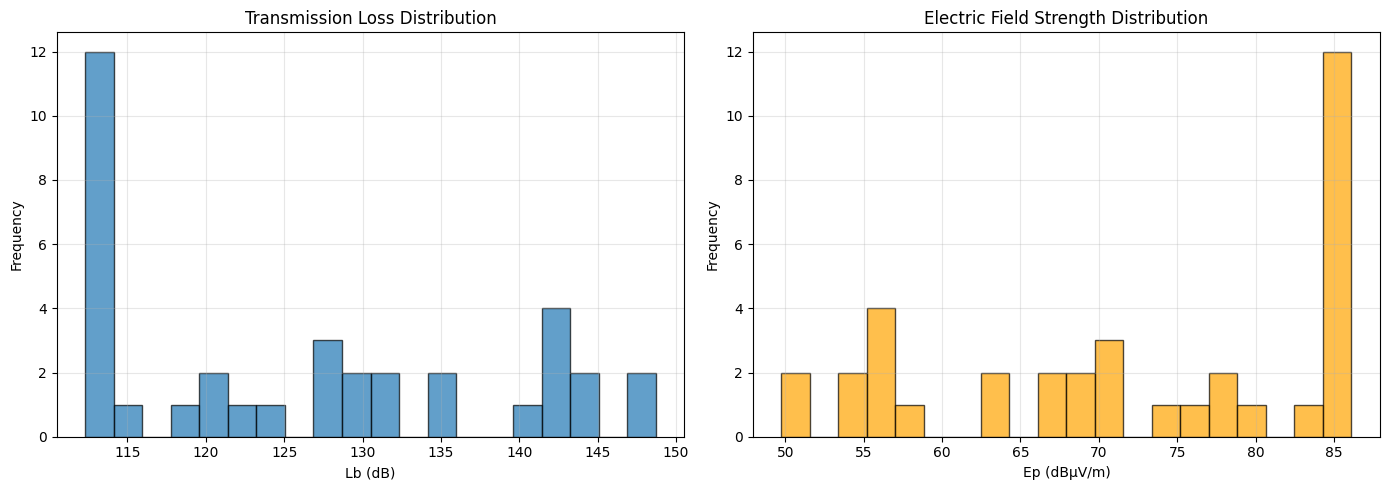

In [16]:
if not results_df.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.hist(results_df['Lb_dB'].dropna(), bins=20, edgecolor='black', alpha=0.7)
    ax1.set_xlabel('Lb (dB)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Transmission Loss Distribution')
    ax1.grid(alpha=0.3)
    
    ax2.hist(results_df['Ep_dBuV_m'].dropna(), bins=20, edgecolor='black', alpha=0.7, color='orange')
    ax2.set_xlabel('Ep (dBμV/m)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Electric Field Strength Distribution')
    ax2.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()